### Generative Adversarial Network to generate face images
 - Inspired from: https://github.com/rasbt/stat453-deep-learning-ss21
 - Tips & Tricks to make GAN training work: https://github.com/soumith/ganhacks

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
# Constants
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
GENERATOR_LR = 2e-4
DISCRIMINATOR_LR = 2e-4

NUM_EPOCHS = 20
BS = 32

IM_HEIGHT, IM_WIDTH, IM_CHANNELS = 64, 64, 3

### Dataset
We will use the [CelebA](https://pytorch.org/vision/stable/generated/torchvision.datasets.CelebA.html) dataset from PyTorch.

In [ ]:
custom_transforms = transforms.Compose([
    transforms.CenterCrop((160, 160)),  # take center crop of 160x160
    transforms.Resize([IM_HEIGHT, IM_WIDTH]),  # resize to 64x64
    transforms.ToTensor(),  # convert from PIL Image to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # change distribution from [0, 1] to [-1, 1]
])

# We won't evaluate the results in any other way than visually => we can use all the data
# I.e., no need for train/valid/test split
celeb_ds = datasets.CelebA(root='data',
                           split='all',
                           transform=custom_transforms,
                           download=True)

celeb_dl = DataLoader(dataset=celeb_ds,
                     batch_size=BS,
                     shuffle=True)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

### Analyze the data

In [ ]:
print(f"Number of images: {len(celeb_ds)}")

images, labels = next(iter(celeb_dl))
print(f"Image batch dimensions: {images.shape}")
print(f"Label dimensions: {labels.shape}")

Number of images: 202599
Image batch dimensions: torch.Size([32, 3, 64, 64])
Label dimensions: torch.Size([32, 40])


#### The labels correspond to features of the person in the image. We won't use them.
Here is a description of these labels:
- 00 - 5_o_Clock_Shadow
- 01 - Arched_Eyebrows
- 02 - Attractive 
- 03 - Bags_Under_Eyes
- 04 - Bald
- 05 - Bangs
- 06 - Big_Lips
- 07 - Big_Nose
- 08 - Black_Hair
- 09 - Blond_Hair
- 10 - Blurry 
- 11 - Brown_Hair 
- 12 - Bushy_Eyebrows 
- 13 - Chubby 
- 14 - Double_Chin 
- 15 - Eyeglasses 
- 16 - Goatee 
- 17 - Gray_Hair 
- 18 - Heavy_Makeup 
- 19 - High_Cheekbones 
- 20 - Male 
- 21 - Mouth_Slightly_Open 
- 22 - Mustache 
- 23 - Narrow_Eyes 
- 24 - No_Beard 
- 25 - Oval_Face 
- 26 - Pale_Skin 
- 27 - Pointy_Nose 
- 28 - Receding_Hairline 
- 29 - Rosy_Cheeks 
- 30 - Sideburns 
- 31 - Smiling 
- 32 - Straight_Hair 
- 33 - Wavy_Hair 
- 34 - Wearing_Earrings 
- 35 - Wearing_Hat 
- 36 - Wearing_Lipstick 
- 37 - Wearing_Necklace 
- 38 - Wearing_Necktie 
- 39 - Young         

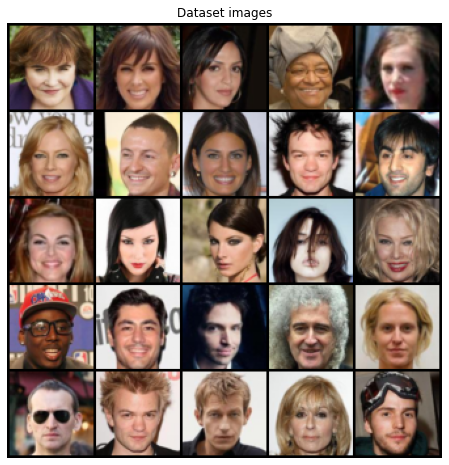

In [ ]:
# visually check some images from the dataset

plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('Dataset images')
plt.imshow(np.transpose(torchvision.utils.make_grid(images[:25], 
                                                    padding=2, 
                                                    normalize=True, 
                                                    value_range=(-1, 1), 
                                                    nrow=5), 
                        (1, 2, 0)))
plt.show()

### Model

In [ ]:
class DCGAN(nn.Module):
    def __init__(self,
                 latent_dim=128, 
                 num_feature_maps_gen=64, 
                 num_feature_maps_dis=64, 
                 nr_color_channels=3):
        super().__init__()   
        
        self.generator = nn.Sequential(
            # input shape is N x latent_dim(=128) x 1 x 1
            nn.ConvTranspose2d(in_channels=latent_dim, 
                               out_channels=num_feature_maps_gen*8, 
                               kernel_size=4, 
                               stride=1, 
                               padding=0),
            nn.BatchNorm2d(num_feature_maps_gen*8),
            nn.LeakyReLU(inplace=True),
            # shape: N x 8*num_feature_maps_gen(=512) x 4 x 4
            
            nn.ConvTranspose2d(in_channels=num_feature_maps_gen*8, 
                               out_channels=num_feature_maps_gen*4, 
                               kernel_size=4, 
                               stride=2, 
                               padding=1),
            nn.BatchNorm2d(num_feature_maps_gen*4),
            nn.LeakyReLU(inplace=True),
            # shape: N x 4*num_feature_maps_gen(=256) x 8 x 8
            
            nn.ConvTranspose2d(in_channels=num_feature_maps_gen*4, 
                               out_channels=num_feature_maps_gen*2, 
                               kernel_size=4, 
                               stride=2, 
                               padding=1),
            nn.BatchNorm2d(num_feature_maps_gen*2),
            nn.LeakyReLU(inplace=True),
            # shape: N x 2*num_feature_maps_gen(=128) x 16 x 16
            
            nn.ConvTranspose2d(in_channels=num_feature_maps_gen*2, 
                               out_channels=num_feature_maps_gen, 
                               kernel_size=4, 
                               stride=2, 
                               padding=1),
            nn.BatchNorm2d(num_feature_maps_gen),
            nn.LeakyReLU(inplace=True),
            # shape: N x num_feature_maps_gen(=64) x 32 x 32
            
            nn.ConvTranspose2d(in_channels=num_feature_maps_gen, 
                               out_channels=nr_color_channels, 
                               kernel_size=4, 
                               stride=2, 
                               padding=1),
            # shape: N x num_feature_maps_gen(=3) x 64 x 64
            nn.Tanh()
        )
        
        self.discriminator = nn.Sequential(
            # input shape is N x C x H x W = 32 x 3 x 64 x 64
            nn.Conv2d(in_channels=nr_color_channels,
                      out_channels=num_feature_maps_dis, 
                      kernel_size=4, 
                      stride=2,
                      padding=1),
            nn.LeakyReLU(inplace=True),
            # shape: N x num_feature_maps_dis(=64) x 32 x 32
            
            nn.Conv2d(in_channels=num_feature_maps_dis,
                      out_channels=num_feature_maps_dis * 2, 
                      kernel_size=4, 
                      stride=2,
                      padding=1),
            nn.LeakyReLU(inplace=True),
            # shape: N x 2*num_feature_maps_dis(=128) x 16 x 16
            
            nn.Conv2d(in_channels=num_feature_maps_dis * 2,
                      out_channels=num_feature_maps_dis * 4, 
                      kernel_size=4, 
                      stride=2,
                      padding=1),
            nn.LeakyReLU(inplace=True),
            # shape: N x 4*num_feature_maps_dis(=256) x 8 x 8
            
            nn.Conv2d(in_channels=num_feature_maps_dis * 4,
                      out_channels=num_feature_maps_dis * 8, 
                      kernel_size=4, 
                      stride=2,
                      padding=1),
            nn.LeakyReLU(inplace=True),
            # shape: N x 8*num_feature_maps_dis(=512) x 4 x 4
            
            nn.Conv2d(in_channels=num_feature_maps_dis * 8,
                      out_channels=1, # just one output corresponding to the class probability
                      kernel_size=4, # kernel_size = height = width => one computation
                      stride=1,
                      padding=0),
            # shape: N x 1 x 1 x 1  -> one class probability for each sample in the batch
            nn.Flatten()
        )
        
    def generator_forward(self, z):
        # z shape: N x latent_dim x 1 x 1
        img = self.generator(z)
        return img  # shape: N x 3 x 64 x 64
    
    def discriminator_forward(self, img):
        # img shape: N x 3 x 64 x 64
        logits = self.discriminator(img)
        return logits  # shape: N x 1

### Test the model outputs correct shapes

In [ ]:
test_model = DCGAN()
N = 32

dummy_img = torch.randn(N, 3, 64, 64)
discr_output = test_model.discriminator_forward(dummy_img)
assert discr_output.shape == torch.Size([N, 1])

dummy_latent = torch.randn(N, 128, 1, 1)
gen_output = test_model.generator_forward(dummy_latent)
assert gen_output.shape == torch.Size([N, 3, 64, 64])

full_output = test_model.discriminator_forward(gen_output)
assert full_output.shape == torch.Size([N, 1])

print("The dimesnions are correct.")

The dimesnions are correct.


### Train the model

In [ ]:
model = DCGAN()
model = model.to(DEVICE)

optim_gen = torch.optim.Adam(model.generator.parameters(),
                            betas=(0.5, 0.999),
                            lr=GENERATOR_LR)

optim_discr = torch.optim.Adam(model.discriminator.parameters(),
                              betas=(0.5, 0.999),
                              lr=DISCRIMINATOR_LR)

loss_fn = F.binary_cross_entropy_with_logits

In [ ]:
# Logging variables
images_from_noise_per_epoch = []
train_generator_loss_per_batch = []
train_discriminator_loss_per_batch = []

In [ ]:
latent_dim = 128
# we will use a fixed noise variable to visually analyze the progress made during training
fixed_noise = torch.randn(25, latent_dim, 1, 1, device=DEVICE)

start_time = time.time()
for epoch in tqdm(list(range(NUM_EPOCHS))):
    model.train()
    
    for batch_idx, (batch, _) in enumerate(celeb_dl):
        batch_size = batch.size(0)
        
        real_images = batch.to(DEVICE)  # shape N x 3 x 64 x 64
        real_labels = torch.ones(batch_size, 1, device=DEVICE)  # shape N x 1
        
        noise = torch.randn(batch_size, latent_dim, 1, 1, device=DEVICE)  # shape N x latent_dim(=128) x 1 x 1
        fake_images = model.generator_forward(noise)  # shape N x 3 x 64 x 64
        fake_labels = torch.zeros(batch_size, 1, device=DEVICE)  # shape N x 1
        flipped_fake_labels = real_labels  # shape N x 1
        
        # Train discriminator
        optim_discr.zero_grad()
        
        discr_pred_real = model.discriminator_forward(real_images)  # shape N x 1
        real_loss = loss_fn(discr_pred_real, real_labels)
        
        discr_pred_fake = model.discriminator_forward(fake_images.detach())  # shape N x 1
        fake_loss = loss_fn(discr_pred_fake, fake_labels)
        
        discr_loss = real_loss + fake_loss
        discr_loss.backward()
        optim_discr.step()
        
        # Train generator
        optim_gen.zero_grad()
        
        discr_pred_fake = model.discriminator_forward(fake_images)  # shape N x 1
        gener_loss = loss_fn(discr_pred_fake, flipped_fake_labels)
        gener_loss.backward()
        optim_gen.step()
        
        # Logging and printing current statistics
        train_generator_loss_per_batch.append(gener_loss.item())
        train_discriminator_loss_per_batch.append(discr_loss.item())
        
        if not batch_idx % 100:
            print("Epoch: %03d/%03d | Batch %03d/%03d | Gen/Dis Loss: %.4f/%.4f"
                 % (epoch + 1, NUM_EPOCHS, batch_idx, len(celeb_dl), gener_loss.item(), discr_loss.item()))
        
    # Generate images using <fixed_noise> for visual inspection
    model.eval()
    with torch.no_grad():
        fake_images = model.generator_forward(fixed_noise).detach().cpu()
        images_from_noise_per_epoch.append(torchvision.utils.make_grid(fake_images, 
                                                                       padding=2, 
                                                                       normalize=True, 
                                                                       value_range=(-1, 1), 
                                                                       nrow=5))
    print("Time elapsed: %.2f min\n" % ((time.time() - start_time) / 60))

print("Total training time: %.2f min" % ((time.time() - start_time) / 60))        
        

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 001/020 | Batch 000/6332 | Gen/Dis Loss: 0.7270/1.3907
Epoch: 001/020 | Batch 100/6332 | Gen/Dis Loss: 2.2808/0.8309
Epoch: 001/020 | Batch 200/6332 | Gen/Dis Loss: 1.1181/1.0717
Epoch: 001/020 | Batch 300/6332 | Gen/Dis Loss: 0.9511/1.1900
Epoch: 001/020 | Batch 400/6332 | Gen/Dis Loss: 0.8747/1.1647
Epoch: 001/020 | Batch 500/6332 | Gen/Dis Loss: 0.8090/1.2832
Epoch: 001/020 | Batch 600/6332 | Gen/Dis Loss: 1.0970/1.2517
Epoch: 001/020 | Batch 700/6332 | Gen/Dis Loss: 1.1599/1.1116
Epoch: 001/020 | Batch 800/6332 | Gen/Dis Loss: 2.4693/0.8445
Epoch: 001/020 | Batch 900/6332 | Gen/Dis Loss: 0.8046/1.2211
Epoch: 001/020 | Batch 1000/6332 | Gen/Dis Loss: 1.6859/0.9061
Epoch: 001/020 | Batch 1100/6332 | Gen/Dis Loss: 1.2936/1.0637
Epoch: 001/020 | Batch 1200/6332 | Gen/Dis Loss: 1.1891/1.0299
Epoch: 001/020 | Batch 1300/6332 | Gen/Dis Loss: 1.9945/1.6485
Epoch: 001/020 | Batch 1400/6332 | Gen/Dis Loss: 1.0694/1.0492
Epoch: 001/020 | Batch 1500/6332 | Gen/Dis Loss: 2.0061/0.7680
Ep

### Check the progress of the model over time by analyzing the output given from the fixed input

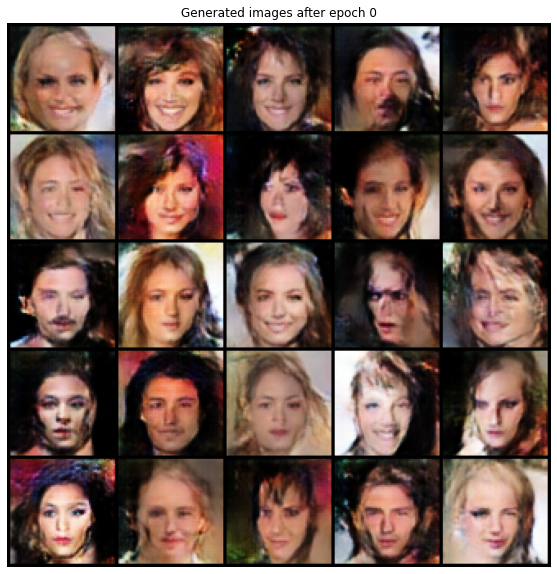

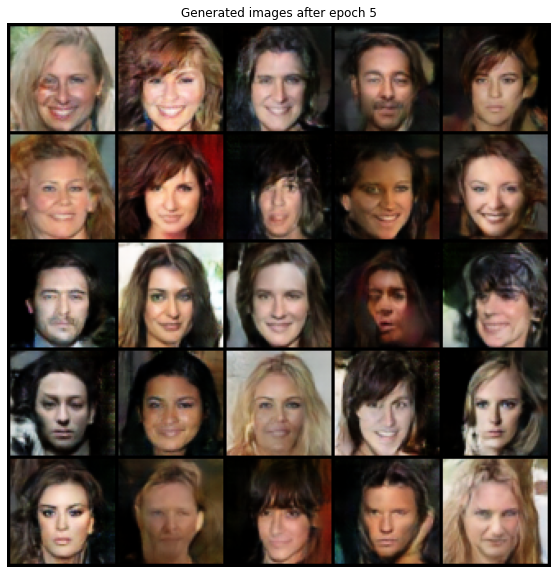

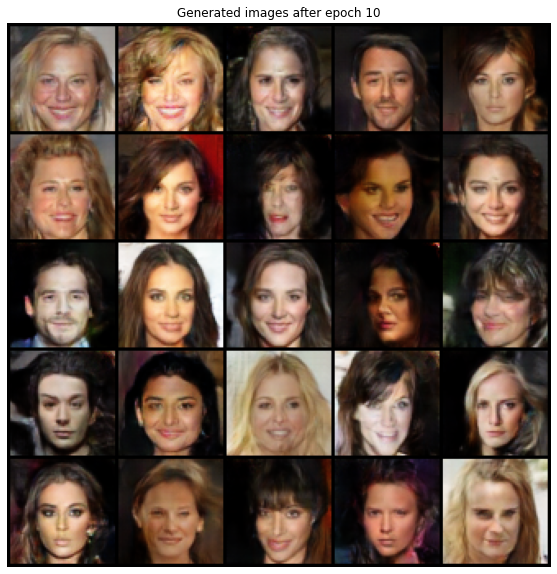

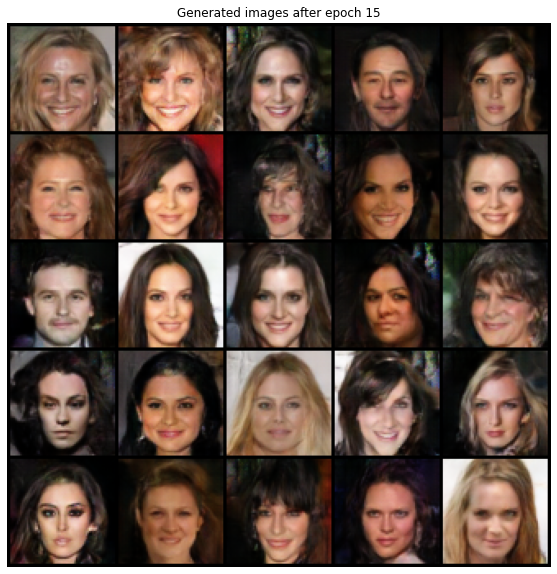

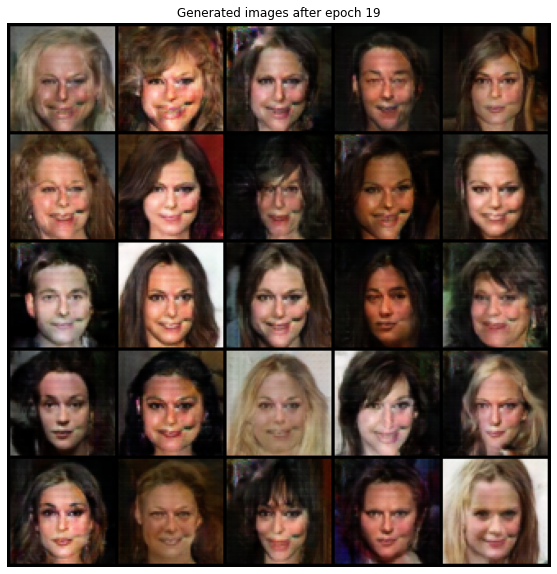

In [ ]:
for i in range(0, NUM_EPOCHS, 5):
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.title(f'Generated images after epoch {i}')
    plt.imshow(np.transpose(images_from_noise_per_epoch[i], (1, 2, 0)))
    plt.show()
  
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.title(f'Generated images after epoch 19')
plt.imshow(np.transpose(images_from_noise_per_epoch[-1], (1, 2, 0)))
plt.show()

### Save the model

In [ ]:
torch.save(model.state_dict(), "/gan.pt")

### Analyze the loss curves

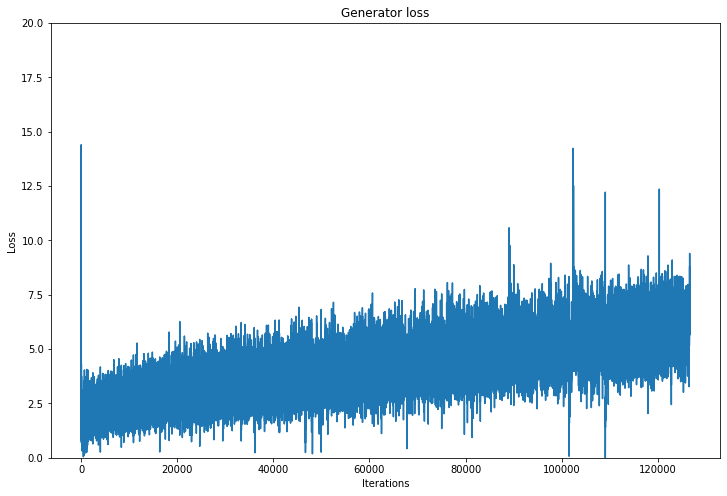

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(train_generator_loss_per_batch)), train_generator_loss_per_batch)
plt.ylim(0, 20)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Generator loss")
plt.show()

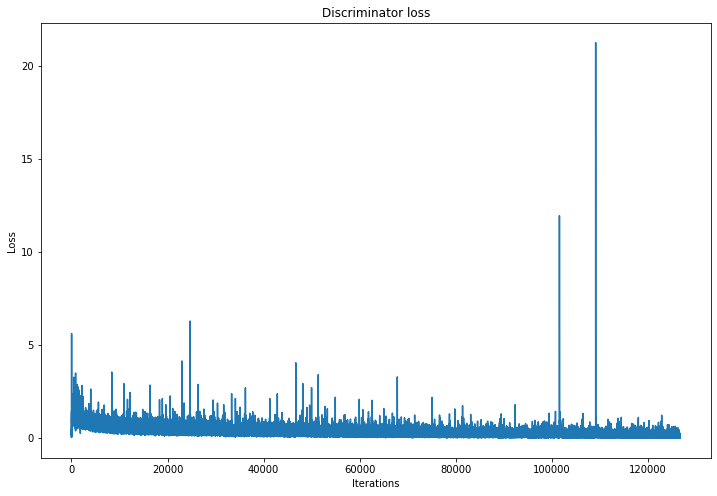

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(train_discriminator_loss_per_batch)), train_discriminator_loss_per_batch)
# plt.ylim(0, 20)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Discriminator loss")
plt.show()

### (Optionally) Load the model

In [ ]:
gan = DCGAN()
gan.load_state_dict(torch.load("/content/gan.pt"))

<All keys matched successfully>